# Data preparation

For the prediction of the outcome of the TEAM A X TEAM B game, we will need to prep our data. What we have now:
A table from our SQL database, in which each row contains information about a single game per team.

As we dont have these informations to actually predict a game, the idea behind the process will be: We are going to fill the row which we want to predict for team A X team B, with concatenated features, taking the mean, from the past N games from team A and past N games from team B. We are going to call this the rolling row.

In order to achieve a more reasonable result, we are not using the stats of a single game and the win situation as a row in the training set. Each row will be the rolling row, E.G., each row will cointain data from the last N games, plus the WIN/LOSS target variable of the actual game. Note that the mean of wins for the rolling will be discarded.

In [23]:
#--------Utilities--------#
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import warnings
import os



#--------Settings--------#
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)

We first gonna extract our stored data from the database created on the webscraping step.

In [24]:
# Get the current working directory
cwd = os.getcwd()

# Navigate up one directory from the current directory to get to main folder
#os.pardir = returns to parent folder when used with os.path.join
main_folder = os.path.abspath(os.path.join(cwd, os.pardir))

# Define the file path to the data in Folder C
data_path = os.path.join(main_folder, "Web Scraping", "nba_games.db")


engine = sqlalchemy.create_engine('sqlite:///' + data_path)

df = pd.read_sql('SELECT * FROM nba_games', con=engine)

Exploring data

In [25]:
df.head()

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,+/-,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,mp_max,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,Team,Total,season,date,home,opponent_index,opponent_mp,opponent_fg,opponent_fga,opponent_fg%,opponent_3p,opponent_3pa,opponent_3p%,opponent_ft,opponent_fta,opponent_ft%,opponent_orb,opponent_drb,opponent_trb,opponent_ast,opponent_stl,opponent_blk,opponent_tov,opponent_pf,opponent_pts,opponent_+/-,opponent_ts%,opponent_efg%,opponent_3par,opponent_ftr,opponent_orb%,opponent_drb%,opponent_trb%,opponent_ast%,opponent_stl%,opponent_blk%,opponent_tov%,opponent_usg%,opponent_ortg,opponent_drtg,opponent_mp_max,opponent_fg_max,opponent_fga_max,opponent_fg%_max,opponent_3p_max,opponent_3pa_max,opponent_3p%_max,opponent_ft_max,opponent_fta_max,opponent_ft%_max,opponent_orb_max,opponent_drb_max,opponent_trb_max,opponent_ast_max,opponent_stl_max,opponent_blk_max,opponent_tov_max,opponent_pf_max,opponent_pts_max,opponent_+/-_max,opponent_ts%_max,opponent_efg%_max,opponent_3par_max,opponent_ftr_max,opponent_orb%_max,opponent_drb%_max,opponent_trb%_max,opponent_ast%_max,opponent_stl%_max,opponent_blk%_max,opponent_tov%_max,opponent_usg%_max,opponent_ortg_max,opponent_drtg_max,opponent_Team,opponent_Total,opponent_season,opponent_date,opponent_home,ID,WIN
0,240.0,36.0,88.0,0.409,8.0,32.0,0.250,19.0,25.0,0.760,9.0,37.0,46.0,24.0,11.0,4.0,10.0,24.0,99.0,None,0.500,0.455,0.364,0.284,18.0,80.4,47.9,66.7,11.1,6.6,9.2,100.0,99.7,102.7,None,11.0,23.0,1.000,4.0,9.0,0.500,5.0,7.0,1.00,4.0,9.0,10.0,10.0,4.0,2.0,3.0,5.0,25.0,8.0,0.798,1.000,1.000,2.000,10.5,26.8,13.7,46.5,9.9,4.5,34.7,29.9,129.0,112.0,BOS,99,2017-18,2017-10-17 00:00:00.000000,0,1,240.0,38.0,83.0,0.458,5.0,22.0,0.227,21.0,25.0,0.840,9.0,41.0,50.0,19.0,3.0,4.0,17.0,25.0,102.0,None,0.543,0.488,0.265,0.301,19.6,82.0,52.1,50.0,3.0,7.1,15.3,100.0,102.7,99.7,None,12.0,19.0,0.667,1.0,5.0,0.333,6.0,7.0,1.00,3.0,15.0,16.0,9.0,2.0,2.0,4.0,4.0,29.0,9.0,0.698,0.667,0.500,1.000,11.0,35.0,19.4,43.7,3.8,6.0,31.6,27.3,138.0,107.0,CLE,102,2017-18,2017-10-17 00:00:00.000000,1,201710170CLE.html,0
1,240.0,38.0,83.0,0.458,5.0,22.0,0.227,21.0,25.0,0.840,9.0,41.0,50.0,19.0,3.0,4.0,17.0,25.0,102.0,None,0.543,0.488,0.265,0.301,19.6,82.0,52.1,50.0,3.0,7.1,15.3,100.0,102.7,99.7,None,12.0,19.0,0.667,1.0,5.0,0.333,6.0,7.0,1.00,3.0,15.0,16.0,9.0,2.0,2.0,4.0,4.0,29.0,9.0,0.698,0.667,0.500,1.000,11.0,35.0,19.4,43.7,3.8,6.0,31.6,27.3,138.0,107.0,CLE,102,2017-18,2017-10-17 00:00:00.000000,1,0,240.0,36.0,88.0,0.409,8.0,32.0,0.250,19.0,25.0,0.760,9.0,37.0,46.0,24.0,11.0,4.0,10.0,24.0,99.0,None,0.500,0.455,0.364,0.284,18.0,80.4,47.9,66.7,11.1,6.6,9.2,100.0,99.7,102.7,None,11.0,23.0,1.000,4.0,9.0,0.500,5.0,7.0,1.00,4.0,9.0,10.0,10.0,4.0,2.0,3.0,5.0,25.0,8.0,0.798,1.000,1.000,2.000,10.5,26.8,13.7,46.5,9.9,4.5,34.7,29.9,129.0,112.0,BOS,99,2017-18,2017-10-17 00:00:00.000000,0,201710170CLE.html,1
2,240.0,47.0,97.0,0.485,15.0,41.0,0.366,13.0,19.0,0.684,10.0,33.0,43.0,28.0,9.0,5.0,12.0,16.0,122.0,None,0.579,0.562,0.423,0.196,22.2,84.6,51.2,59.6,8.8,10.0,10.2,100.0,119.6,118.6,None,10.0,23.0,0.667,4.0,9.0,0.667,6.0,8.0,0.75,3.0,7.0,8.0,11.0,2.0,2.0,3.0,4.0,27.0,20.0,0.859,0.889,0.667,0.667,9.6,26.1,13.8,42.9,2.8,6.5,18.2,31.2,152.0,126.0,HOU,122,2017-18,2017-10-17 00:00:00.000000,0,1,240.0,43.0,80.0,0.538,16.0,30.0,0.533,19.0,21.0,0.905,6.0,35.0,41.0,34.0,5.0,9.0,17.0,25.0,121.0,None,0.678,0.638,0.375,0.263,15.4,77.8,48.8,79.1,4.9,16.1,16.0,100.0,118.6,119.6,None,8.0,18.0,1.000,6.0,9.0,0.857,4.0,5.0,1.00,1.0,10.0,11.0,13.0,2.0,4.0,8.0,4.0,23.0,11.0,1.218,1.222,0.778,1.000,13.1,38.6,22.7,57.1,6.1,9.1,31.7,32.6,250.0,127.0,GSW,121,2017-18,2017-10-17 00:00:00.000000,1,201710170GSW.html,1
3,240.0,43.0,80.0,0.538,16.0,30.0

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14910 entries, 0 to 14909
Columns: 149 entries, mp to WIN
dtypes: float64(132), int64(6), object(11)
memory usage: 16.9+ MB


In [27]:
df.columns.to_list()

['mp',
 'fg',
 'fga',
 'fg%',
 '3p',
 '3pa',
 '3p%',
 'ft',
 'fta',
 'ft%',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 '+/-',
 'ts%',
 'efg%',
 '3par',
 'ftr',
 'orb%',
 'drb%',
 'trb%',
 'ast%',
 'stl%',
 'blk%',
 'tov%',
 'usg%',
 'ortg',
 'drtg',
 'mp_max',
 'fg_max',
 'fga_max',
 'fg%_max',
 '3p_max',
 '3pa_max',
 '3p%_max',
 'ft_max',
 'fta_max',
 'ft%_max',
 'orb_max',
 'drb_max',
 'trb_max',
 'ast_max',
 'stl_max',
 'blk_max',
 'tov_max',
 'pf_max',
 'pts_max',
 '+/-_max',
 'ts%_max',
 'efg%_max',
 '3par_max',
 'ftr_max',
 'orb%_max',
 'drb%_max',
 'trb%_max',
 'ast%_max',
 'stl%_max',
 'blk%_max',
 'tov%_max',
 'usg%_max',
 'ortg_max',
 'drtg_max',
 'Team',
 'Total',
 'season',
 'date',
 'home',
 'opponent_index',
 'opponent_mp',
 'opponent_fg',
 'opponent_fga',
 'opponent_fg%',
 'opponent_3p',
 'opponent_3pa',
 'opponent_3p%',
 'opponent_ft',
 'opponent_fta',
 'opponent_ft%',
 'opponent_orb',
 'opponent_drb',
 'opponent_trb',
 'opponent_ast',
 'opp

Excluding ID row

In [28]:
df = df.loc[:, df.columns != 'ID'] #type: ignore

## Checking for duplicates and deleting if theres any

In [29]:
df.duplicated().sum()
df = df.drop_duplicates(keep='first')

## Overtime exceptions
We are going to delete some non useful or redundant info, as well as the rows where the number of minutes played != 240, because these are some outliers that represent much less than 15% of our data, and we will then remove the  mp variable alltogheter

Text(0, 0.5, 'Games Played')

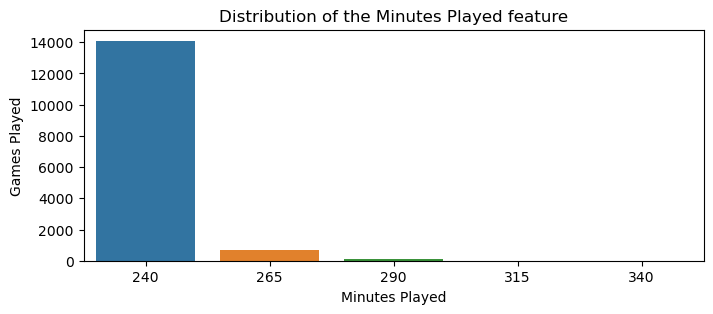

In [30]:
plt.figure(num=1, figsize=(8, 3))

plt.title('Distribution of the Minutes Played feature')
sns.countplot(df['mp'].astype(int)); #type: ignore
plt.xlabel('Minutes Played')
plt.ylabel('Games Played')


In [31]:
print('outliers porcentage: {:.2%}'.format(len(df[df['mp'] != 240])/len(df)))

 #deleting outliers rows   
df = df[df['mp'] == 240]
df.shape

outliers porcentage: 5.47%


(14094, 148)

* We need just one stat for minutes played;
* we will need the +/-_max stats, because the max diference that a player made could be important;
* altough the team name, season, and date are irrelevant for training, they will be important for organization. But these stats for the opponent side could be deleted;


In [34]:
def del_cols(df, cols):
    """ Info:
        This function deletes the columns that are not needed for the analysis.
         It will first check to see if it exists in the dataframe, and if it does, it will delete it.
         -------------------------------------------------------------------------------------------
        Input:
          df: dataframe
           cols: list of columns to be deleted
         -------------------------------------------------------------------------------------------
        Output:
            df: dataframe without the columns that were deleted """
    col_list = []
    for col in cols:
        if col in df.columns:
            col_list.append(col)

    df.drop(col_list, axis=1, inplace=True)
    return df

In [35]:
del_list = ['mp','mp.1','+/-','mp_max','mp_max.1',
 'opponent_index','opponent_mp',
 'opponent_mp.1','opponent_+/-','opponent_mp_max.1', 'opponent_mp_max',
   'opponent_date', 'opponent_season', 'opponent_home']


df = del_cols(df, del_list)
df.shape

(14094, 138)

In [36]:
df.shape

(14094, 138)

## Decision point

This is a crucial step. The dataset here will be considered clean and ready for use, as the EDA notebooks confirmed data this data is optimal. 

 - We are going to save this dataframe, so when we need to do a single new prediction in production, the last n games with means stats used as input will come from this dataset, that we are going to save as production df with pickle.
 - This dataset also will be transformed into a rolling dataset, that will be used for training. This will be the dataset that we will use to train our model. It will be saved as data_base with pickle.

In [40]:
#saving the dataframe to pickle file
df.to_pickle('production_df.pkl')

#loading the dataframe from pickle file
df = pd.read_pickle('production_df.pkl')

In [38]:
df.columns.to_list()

['fg',
 'fga',
 'fg%',
 '3p',
 '3pa',
 '3p%',
 'ft',
 'fta',
 'ft%',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 'ts%',
 'efg%',
 '3par',
 'ftr',
 'orb%',
 'drb%',
 'trb%',
 'ast%',
 'stl%',
 'blk%',
 'tov%',
 'usg%',
 'ortg',
 'drtg',
 'fg_max',
 'fga_max',
 'fg%_max',
 '3p_max',
 '3pa_max',
 '3p%_max',
 'ft_max',
 'fta_max',
 'ft%_max',
 'orb_max',
 'drb_max',
 'trb_max',
 'ast_max',
 'stl_max',
 'blk_max',
 'tov_max',
 'pf_max',
 'pts_max',
 '+/-_max',
 'ts%_max',
 'efg%_max',
 '3par_max',
 'ftr_max',
 'orb%_max',
 'drb%_max',
 'trb%_max',
 'ast%_max',
 'stl%_max',
 'blk%_max',
 'tov%_max',
 'usg%_max',
 'ortg_max',
 'drtg_max',
 'Team',
 'Total',
 'season',
 'date',
 'home',
 'opponent_fg',
 'opponent_fga',
 'opponent_fg%',
 'opponent_3p',
 'opponent_3pa',
 'opponent_3p%',
 'opponent_ft',
 'opponent_fta',
 'opponent_ft%',
 'opponent_orb',
 'opponent_drb',
 'opponent_trb',
 'opponent_ast',
 'opponent_stl',
 'opponent_blk',
 'opponent_tov',
 'opponent_pf',

Our traning set has to match our predict idea, so each row will be the mean of last few games for each team.
Note that as we are taking last n games per team, conseidering season, and home stats, will lose some information in this way:

if we chose to roll with n games, only the information with n+1 will appear as a row. It means that we lose 2*n rows per team, as each team  are grouped by home or away also.

* Example:
For n = 10 games, being a season having 30 teams, we lose 2 * 10 * 30 = 600 rows per season. But, as we have almost 2500 games in a regular season, it is worth it still, to try numbers like 5 < n < 15

In [41]:
def team_avg(grouped_df, last_n_games=6):
    """ Info:
        This function calculates the rolling average of the features of the team

         Input:
            last_n_games: number of games a team played to calculate the rolling average 
            grouped_df: dataframe grouped by team, season, and home status

             Output:
                rolling: dataframe with the rolling average of the features """
    
    rolling = grouped_df.rolling(last_n_games).mean()
    return rolling

In [42]:
# creating our list of feature cols for ML
info_cols = ['date', 'Team', 'opponent_Team', 'season', 'home', 'WIN']
model_cols = df.columns[~df.columns.isin(info_cols)]	#only usefull for ML columns

In [43]:
#df for rolling is the df with the top valuable features for training plus the columns that we need for the group by.
# Note that these are columns from the information cols.
df_to_roll = df[list(model_cols) + ['Team','season', 'home'] ]
df_rolling = df_to_roll.groupby(['Team','season', 'home'], group_keys=False).apply(team_avg)
df_rolling.shape

(14094, 133)

In [44]:
df_rolling.tail()

,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,Total,opponent_fg,opponent_fga,opponent_fg%,opponent_3p,opponent_3pa,opponent_3p%,opponent_ft,opponent_fta,opponent_ft%,opponent_orb,opponent_drb,opponent_trb,opponent_ast,opponent_stl,opponent_blk,opponent_tov,opponent_pf,opponent_pts,opponent_ts%,opponent_efg%,opponent_3par,opponent_ftr,opponent_orb%,opponent_drb%,opponent_trb%,opponent_ast%,opponent_stl%,opponent_blk%,opponent_tov%,opponent_usg%,opponent_ortg,opponent_drtg,opponent_fg_max,opponent_fga_max,opponent_fg%_max,opponent_3p_max,opponent_3pa_max,opponent_3p%_max,opponent_ft_max,opponent_fta_max,opponent_ft%_max,opponent_orb_max,opponent_drb_max,opponent_trb_max,opponent_ast_max,opponent_stl_max,opponent_blk_max,opponent_tov_max,opponent_pf_max,opponent_pts_max,opponent_+/-_max,opponent_ts%_max,opponent_efg%_max,opponent_3par_max,opponent_ftr_max,opponent_orb%_max,opponent_drb%_max,opponent_trb%_max,opponent_ast%_max,opponent_stl%_max,opponent_blk%_max,opponent_tov%_max,opponent_usg%_max,opponent_ortg_max,opponent_drtg_max,opponent_Total,home
14903,46.666667,92.666667,0.504333,12.666667,32.833333,0.389667,19.666667,25.666667,0.774833,11.833333,27.500000,39.333333,29.166667,6.500000,4.166667,12.666667,20.500000,125.666667,0.605333,0.572833,0.354667,0.278333,26.900000,74.283333,48.766667,62.366667,6.366667,7.716667,10.866667,100.0,123.516667,134.383333,9.833333,18.000000,0.802667,3.666667,7.833333,0.791667,7.166667,7.833333,1.000000,4.166667,7.333333,10.166667,11.166667,2.333333,2.166667,4.000000,4.833333,26.500000,NaN,0.861500,0.876333,0.743000,1.271333,19.983333,33.250000,22.550000,56.050000,4.400000,8.483333,27.016667,30.416667,183.666667,140.000000,125.666667,50.166667,89.000000,0.564333,13.500000,34.500000,0.385000,22.666667,27.666667,0.813500,10.000000,31.333333,41.333333,30.000000,8.666667,5.833333,12.166667,21.500000,136.500000,0.676833,0.640667,0.388167,0.312833,25.716667,73.100000,51.233333,59.983333,8.583333,9.783333,10.650000,100.0,134.383333,123.516667,12.666667,21.500000,0.879667,4.500000,9.166667,0.784167,11.000000,12.500000,1.000000,3.500000,8.333333,11.000000,10.000000,3.333333,3.166667,3.833333,4.666667,37.833333,NaN,1.016500,1.007000,0.901000,0.857333,18.583333,39.100000,23.883333,44.600000,6.566667,16.583333,67.333333,36.016667,209.333333,131.666667,136.500000,1.0
14904,43.500000,88.333333,0.492333,11.000000,30.666667,0.364167,23.500000,29.500000,0.791333,12.500000,34.333333,46.833333,26.333333,7.166667,4.000000,12.500000,15.000000,121.500000,0.600833,0.555333,0.348500,0.334167,30.166667,75.166667,53.450000,60.350000,7.216667,6.883333,10.933333,100.0,122.916667,114.066667,12.166667,20.166667,0.837500,3.833333,8.166667,0.875000,9.500000,11.166667,1.000000,5.666667,8.500000,13.333333,7.500000,1.833333,2.000000,3.666667,4.166667,34.666667,NaN,0.964500,0.980000,0.877833,1.107167,22.233333,34.950000,23.950000,39.833333,5.933333,6.200000,32.050000,39.733333,182.333333,122.166667,121.500000,43.666667,92.333333,0.475833,11.666667,35.666667,0.327333,13.833333,18.000000,0.770333,11.666667,29.166667,40.833333,24.500000,7.833333,3.666667,13.166667,22.166667,112.833333,0.565500,0.539667,0.387167,0.198667,24.833333,69.833333,46.550000,56.216667,7.883333,6.416667,11.616667,100.0,114.066667,122.916667,9.666667,17.666667,0.833500,3.833333,8.000000,0.822333,6.166667,7.666667,1.000000,4.333333,7.666667,11.166667,7.000000,2.333333,2.000000,3.833333,4.833333,25.666667,NaN,0.903333,0.893667,0.875000,0.770167,22.500000,46.266667,26.366667,36.033333,3.566667,5.666667,30.166667,34.616667,168.333333,130.833333,112.833333,0.0
14905,43.333333,83.000000,0.523500,13.500000,33.

Checking for null values

In [45]:
def check_missing_col(dataframe):
    """ Info:
        This function checks if there are missing values in the dataframe
         Input:
            dataframe: dataframe to check
             Output:
              prints the columns with missing values and the number of missing values """
    i = 0
    for col in dataframe.columns:
        if dataframe[col].isnull().sum() > 0:
            print(col, dataframe[col].isna().sum())
            i += 1

    if i == 0:
        print( 'no missing values')

In [46]:
check_missing_col(df_rolling)
df_to_roll.shape

fg 1800
fga 1800
fg% 1800
3p 1800
3pa 1800
3p% 1800
ft 1800
fta 1800
ft% 1800
orb 1800
drb 1800
trb 1800
ast 1800
stl 1800
blk 1800
tov 1800
pf 1800
pts 1800
ts% 1800
efg% 1800
3par 1800
ftr 1800
orb% 1800
drb% 1800
trb% 1800
ast% 1800
stl% 1800
blk% 1800
tov% 1800
usg% 1800
ortg 1800
drtg 1800
fg_max 1800
fga_max 1800
fg%_max 1800
3p_max 1800
3pa_max 1800
3p%_max 1800
ft_max 1800
fta_max 1800
ft%_max 1800
orb_max 1800
drb_max 1800
trb_max 1800
ast_max 1800
stl_max 1800
blk_max 1800
tov_max 1800
pf_max 1800
pts_max 1800
+/-_max 1832
ts%_max 1800
efg%_max 1800
3par_max 1800
ftr_max 1800
orb%_max 1800
drb%_max 1800
trb%_max 1800
ast%_max 1800
stl%_max 1800
blk%_max 1800
tov%_max 1800
usg%_max 1800
ortg_max 1800
drtg_max 1800
Total 1800
opponent_fg 1800
opponent_fga 1800
opponent_fg% 1800
opponent_3p 1800
opponent_3pa 1800
opponent_3p% 1800
opponent_ft 1800
opponent_fta 1800
opponent_ft% 1800
opponent_orb 1800
opponent_drb 1800
opponent_trb 1800
opponent_ast 1800
opponent_stl 1800
opponen

(14094, 135)

Combining our avg rows with our original dataframe;
So we gonna keep only thse informations cols from our original df. In this way, our model will train only with respect of th e past games information for that team, even though there are information in training for the actual game. This is so we can use only what is possible to use for prediction, making it more reliable.

In [47]:
df_rolling.columns.tolist()

['fg',
 'fga',
 'fg%',
 '3p',
 '3pa',
 '3p%',
 'ft',
 'fta',
 'ft%',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 'ts%',
 'efg%',
 '3par',
 'ftr',
 'orb%',
 'drb%',
 'trb%',
 'ast%',
 'stl%',
 'blk%',
 'tov%',
 'usg%',
 'ortg',
 'drtg',
 'fg_max',
 'fga_max',
 'fg%_max',
 '3p_max',
 '3pa_max',
 '3p%_max',
 'ft_max',
 'fta_max',
 'ft%_max',
 'orb_max',
 'drb_max',
 'trb_max',
 'ast_max',
 'stl_max',
 'blk_max',
 'tov_max',
 'pf_max',
 'pts_max',
 '+/-_max',
 'ts%_max',
 'efg%_max',
 '3par_max',
 'ftr_max',
 'orb%_max',
 'drb%_max',
 'trb%_max',
 'ast%_max',
 'stl%_max',
 'blk%_max',
 'tov%_max',
 'usg%_max',
 'ortg_max',
 'drtg_max',
 'Total',
 'opponent_fg',
 'opponent_fga',
 'opponent_fg%',
 'opponent_3p',
 'opponent_3pa',
 'opponent_3p%',
 'opponent_ft',
 'opponent_fta',
 'opponent_ft%',
 'opponent_orb',
 'opponent_drb',
 'opponent_trb',
 'opponent_ast',
 'opponent_stl',
 'opponent_blk',
 'opponent_tov',
 'opponent_pf',
 'opponent_pts',
 'opponent_ts%',
 'o

In [48]:
# first, we rename the columns to add the rolling prefix
df_rolling.columns = ['rolling_' + col for col in df_rolling.columns]
# then, we merge the rolling df with the original df
df_combined = df[['date', 'home', 'Team', 'opponent_Team', 'season', 'WIN']].merge(df_rolling, left_index=True, right_index=True)
print(df_combined.shape)
df_combined[[ 'date', 'home', 'Team', 'opponent_Team','season', 'rolling_pts', 'rolling_opponent_pts', 'WIN']].tail()

(14094, 139)


,date,home,Team,opponent_Team,season,rolling_pts,rolling_opponent_pts,WIN
14903,2023-04-05 00:00:00.000000,1,IND,NYK,2022-23,125.666667,136.500000,0
14904,2023-04-05 00:00:00.000000,0,LAL,LAC,2022-23,121.500000,112.833333,0
14905,2023-04-05 00:00:00.000000,1,LAC,LAL,2022-23,115.666667,113.333333,1
14906,2023-04-05 00:00:00.000000,0,CHI,MIL,2022-23,114.333333,105.833333,0
14907,2023-04-05 00:00:00.000000,1,MIL,CHI,2022-23,115.333333,113.333333,1


From the end of the dataframe, we can see that we have reliable features because for example, even tho the avg points of past n games of the A team were higher then the last n opponents avg, they still lost the actual game IN SOME ROWS

We have N/A stats of those games that the team did not had the full n games stats prior to the actual row, so the rolling function atributes as na. To undestand in more detail, please refer to https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html.

In [64]:
#checking for missing values and its date and team == 'BOS'
df_combined[df_combined['rolling_pts'].isnull() & (df_combined['Team'] == 'BOS')].head(21).reset_index()

,index,date,home,Team,opponent_Team,season,WIN,rolling_fg,rolling_fga,rolling_fg%,rolling_3p,rolling_3pa,rolling_3p%,rolling_ft,rolling_fta,rolling_ft%,rolling_orb,rolling_drb,rolling_trb,rolling_ast,rolling_stl,rolling_blk,rolling_tov,rolling_pf,rolling_pts,rolling_ts%,rolling_efg%,rolling_3par,rolling_ftr,rolling_orb%,rolling_drb%,rolling_trb%,rolling_ast%,rolling_stl%,rolling_blk%,rolling_tov%,rolling_usg%,rolling_ortg,rolling_drtg,rolling_fg_max,rolling_fga_max,rolling_fg%_max,rolling_3p_max,rolling_3pa_max,rolling_3p%_max,rolling_ft_max,rolling_fta_max,rolling_ft%_max,rolling_orb_max,rolling_drb_max,rolling_trb_max,rolling_ast_max,rolling_stl_max,rolling_blk_max,rolling_tov_max,rolling_pf_max,rolling_pts_max,rolling_+/-_max,rolling_ts%_max,rolling_efg%_max,rolling_3par_max,rolling_ftr_max,rolling_orb%_max,rolling_drb%_max,rolling_trb%_max,rolling_ast%_max,rolling_stl%_max,rolling_blk%_max,rolling_tov%_max,rolling_usg%_max,rolling_ortg_max,rolling_drtg_max,rolling_Total,rolling_opponent_fg,rolling_opponent_fga,rolling_opponent_fg%,rolling_opponent_3p,rolling_opponent_3pa,rolling_opponent_3p%,rolling_opponent_ft,rolling_opponent_fta,rolling_opponent_ft%,rolling_opponent_orb,rolling_opponent_drb,rolling_opponent_trb,rolling_opponent_ast,rolling_opponent_stl,rolling_opponent_blk,rolling_opponent_tov,rolling_opponent_pf,rolling_opponent_pts,rolling_opponent_ts%,rolling_opponent_efg%,rolling_opponent_3par,rolling_opponent_ftr,rolling_opponent_orb%,rolling_opponent_drb%,rolling_opponent_trb%,rolling_opponent_ast%,rolling_opponent_stl%,rolling_opponent_blk%,rolling_opponent_tov%,rolling_opponent_usg%,rolling_opponent_ortg,rolling_opponent_drtg,rolling_opponent_fg_max,rolling_opponent_fga_max,rolling_opponent_fg%_max,rolling_opponent_3p_max,rolling_opponent_3pa_max,rolling_opponent_3p%_max,rolling_opponent_ft_max,rolling_opponent_fta_max,rolling_opponent_ft%_max,rolling_opponent_orb_max,rolling_opponent_drb_max,rolling_opponent_trb_max,rolling_opponent_ast_max,rolling_opponent_stl_max,rolling_opponent_blk_max,rolling_opponent_tov_max,rolling_opponent_pf_max,rolling_opponent_pts_max,rolling_opponent_+/-_max,rolling_opponent_ts%_max,rolling_opponent_efg%_max,rolling_opponent_3par_max,rolling_opponent_ftr_max,rolling_opponent_orb%_max,rolling_opponent_drb%_max,rolling_opponent_trb%_max,rolling_opponent_ast%_max,rolling_opponent_stl%_max,rolling_opponent_blk%_max,rolling_opponent_tov%_max,rolling_opponent_usg%_max,rolling_opponent_ortg_max,rolling_opponent_drtg_max,rolling_opponent_Total,rolling_home
0,0,2017-10-17 00:00:00.000000,0,BOS,CLE,2017-18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,2017-10-18 00:00:00.000000,1,BOS,MIL,2017-18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,46,2017-10-20 00:00:00.000000,0,BOS,PHI,2017-18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In this example above, we have the first games of team 'BOS' in the season of 2018, plus some first games of its opponents. So, for the first 10 games of BOS, we dont have the rolling stats, because we dont have the past 10 games of the opponents. So, we will have to drop these rows.

In [65]:
print(df_combined.isna().sum())

date                            0
home                            0
Team                            0
opponent_Team                   0
season                          0
                             ... 
rolling_opponent_usg%_max    1800
rolling_opponent_ortg_max    1800
rolling_opponent_drtg_max    1800
rolling_opponent_Total       1800
rolling_home                 1800
Length: 139, dtype: int64


In [66]:
# deleting the rows with missing values
df_combined.dropna(inplace=True)
df_combined.shape

(12259, 139)

In [67]:
df_combined.iloc[2000:2005]

,date,home,Team,opponent_Team,season,WIN,rolling_fg,rolling_fga,rolling_fg%,rolling_3p,rolling_3pa,rolling_3p%,rolling_ft,rolling_fta,rolling_ft%,rolling_orb,rolling_drb,rolling_trb,rolling_ast,rolling_stl,rolling_blk,rolling_tov,rolling_pf,rolling_pts,rolling_ts%,rolling_efg%,rolling_3par,rolling_ftr,rolling_orb%,rolling_drb%,rolling_trb%,rolling_ast%,rolling_stl%,rolling_blk%,rolling_tov%,rolling_usg%,rolling_ortg,rolling_drtg,rolling_fg_max,rolling_fga_max,rolling_fg%_max,rolling_3p_max,rolling_3pa_max,rolling_3p%_max,rolling_ft_max,rolling_fta_max,rolling_ft%_max,rolling_orb_max,rolling_drb_max,rolling_trb_max,rolling_ast_max,rolling_stl_max,rolling_blk_max,rolling_tov_max,rolling_pf_max,rolling_pts_max,rolling_+/-_max,rolling_ts%_max,rolling_efg%_max,rolling_3par_max,rolling_ftr_max,rolling_orb%_max,rolling_drb%_max,rolling_trb%_max,rolling_ast%_max,rolling_stl%_max,rolling_blk%_max,rolling_tov%_max,rolling_usg%_max,rolling_ortg_max,rolling_drtg_max,rolling_Total,rolling_opponent_fg,rolling_opponent_fga,rolling_opponent_fg%,rolling_opponent_3p,rolling_opponent_3pa,rolling_opponent_3p%,rolling_opponent_ft,rolling_opponent_fta,rolling_opponent_ft%,rolling_opponent_orb,rolling_opponent_drb,rolling_opponent_trb,rolling_opponent_ast,rolling_opponent_stl,rolling_opponent_blk,rolling_opponent_tov,rolling_opponent_pf,rolling_opponent_pts,rolling_opponent_ts%,rolling_opponent_efg%,rolling_opponent_3par,rolling_opponent_ftr,rolling_opponent_orb%,rolling_opponent_drb%,rolling_opponent_trb%,rolling_opponent_ast%,rolling_opponent_stl%,rolling_opponent_blk%,rolling_opponent_tov%,rolling_opponent_usg%,rolling_opponent_ortg,rolling_opponent_drtg,rolling_opponent_fg_max,rolling_opponent_fga_max,rolling_opponent_fg%_max,rolling_opponent_3p_max,rolling_opponent_3pa_max,rolling_opponent_3p%_max,rolling_opponent_ft_max,rolling_opponent_fta_max,rolling_opponent_ft%_max,rolling_opponent_orb_max,rolling_opponent_drb_max,rolling_opponent_trb_max,rolling_opponent_ast_max,rolling_opponent_stl_max,rolling_opponent_blk_max,rolling_opponent_tov_max,rolling_opponent_pf_max,rolling_opponent_pts_max,rolling_opponent_+/-_max,rolling_opponent_ts%_max,rolling_opponent_efg%_max,rolling_opponent_3par_max,rolling_opponent_ftr_max,rolling_opponent_orb%_max,rolling_opponent_drb%_max,rolling_opponent_trb%_max,rolling_opponent_ast%_max,rolling_opponent_stl%_max,rolling_opponent_blk%_max,rolling_opponent_tov%_max,rolling_opponent_usg%_max,rolling_opponent_ortg_max,rolling_opponent_drtg_max,rolling_opponent_Total,rolling_home
2418,2018-04-09 00:00:00.000000,0,MEM,MIN,2017-18,0,36.833333,84.833333,0.434500,8.666667,23.833333,0.352833,11.666667,15.500000,0.739333,8.833333,27.833333,36.666667,20.166667,7.833333,4.333333,16.666667,21.000000,94.000000,0.513667,0.485167,0.279833,0.184167,20.166667,73.366667,45.000000,54.300000,8.150000,8.450000,15.300000,100.0,97.900000,119.166667,9.166667,17.166667,0.761667,3.666667,6.833333,0.726167,4.166667,4.666667,1.000000,2.333333,7.000000,8.833333,5.333333,2.500000,1.666667,4.166667,4.333333,23.333333,3.333333,0.828000,0.8295,0.619833,1.151167,13.400000,37.350000,20.300000,42.783333,6.366667,8.716667,40.733333,36.033333,147.500000,127.166667,94.000000,41.333333,83.666667,0.493667,12.333333,31.833333,0.378833,19.833333,24.500000,0.813667,10.333333,34.833333,45.166667,26.166667,9.500000,5.166667,13.833333,17.166667,114.833333,0.606667,0.566833,0.380333,0.294333,26.633333,79.833333,55.000000,63.633333,9.800000,8.583333,12.800000,100.0,119.166667,97.900000,9.666667,16.833333,0.846333,4.666667,9.000000,0.875000,9.500000,10.833333,1.000000,3.666667,9.666667,12.333333,8.833333,2.833333,2.500000,3.500000,4.000000,29.000000,29.166667,1.047500,1.037167,0.902833,0.988833,21.816667,57.450000,37.733333,52.400000,6.050000,7.633333,58.550000,33.433333,202.666667,107.333333,114.833333,0.0
2419,2018-04-09 00:00:00.000000,1,MIN,MEM,2017-18,1,41.833333,86.333333,0.483667,9.333333,24.166667,0.386167,19.000000,22.500000,0.850667,9.833333,30.000000,39.8

We now have rows for each team, being each the last n games. Those are also tagged propperly in order with the date/ index right sorting. We should add those cols for the opponent team too. As in a prediction, we would have the information about the past n games, plus the home, season, and date, and of course the win/loss.


We can do this by combining a dataframe with the home teams names with a dataframe with away teams. We do this by joining the columns 'Team' and 'opponent_Team' and  using the date as same index.


In [68]:
# creating the home and away df

home = df_combined.loc[df_combined['home'] == 1]
# adding the home prefix to the columns
home.columns = ['home_' + col for col in home.columns] #type: ignore

away = df_combined.loc[df_combined['home'] == 0]
# adding the away prefix to the columns 
away.columns = ['away_' + col for col in away.columns] #type: ignore


In [69]:
away.columns.to_list()

['away_date',
 'away_home',
 'away_Team',
 'away_opponent_Team',
 'away_season',
 'away_WIN',
 'away_rolling_fg',
 'away_rolling_fga',
 'away_rolling_fg%',
 'away_rolling_3p',
 'away_rolling_3pa',
 'away_rolling_3p%',
 'away_rolling_ft',
 'away_rolling_fta',
 'away_rolling_ft%',
 'away_rolling_orb',
 'away_rolling_drb',
 'away_rolling_trb',
 'away_rolling_ast',
 'away_rolling_stl',
 'away_rolling_blk',
 'away_rolling_tov',
 'away_rolling_pf',
 'away_rolling_pts',
 'away_rolling_ts%',
 'away_rolling_efg%',
 'away_rolling_3par',
 'away_rolling_ftr',
 'away_rolling_orb%',
 'away_rolling_drb%',
 'away_rolling_trb%',
 'away_rolling_ast%',
 'away_rolling_stl%',
 'away_rolling_blk%',
 'away_rolling_tov%',
 'away_rolling_usg%',
 'away_rolling_ortg',
 'away_rolling_drtg',
 'away_rolling_fg_max',
 'away_rolling_fga_max',
 'away_rolling_fg%_max',
 'away_rolling_3p_max',
 'away_rolling_3pa_max',
 'away_rolling_3p%_max',
 'away_rolling_ft_max',
 'away_rolling_fta_max',
 'away_rolling_ft%_max',
 'aw

We need to swap the names of the columns in the away team so it is considered the opponent team

In [70]:
# to join the columns, we need to rename the team columns on the away df
away.rename(columns={'away_Team': 'away_team','away_opponent_Team': 'home_team', 'away_date': 'date'}, inplace=True) 
home.rename(columns={'home_Team': 'home_team', 'home_opponent_Team': 'away_team', 'home_date': 'date'}, inplace=True)

In [71]:
home

,date,home_home,home_team,away_team,home_season,home_WIN,home_rolling_fg,home_rolling_fga,home_rolling_fg%,home_rolling_3p,home_rolling_3pa,home_rolling_3p%,home_rolling_ft,home_rolling_fta,home_rolling_ft%,home_rolling_orb,home_rolling_drb,home_rolling_trb,home_rolling_ast,home_rolling_stl,home_rolling_blk,home_rolling_tov,home_rolling_pf,home_rolling_pts,home_rolling_ts%,home_rolling_efg%,home_rolling_3par,home_rolling_ftr,home_rolling_orb%,home_rolling_drb%,home_rolling_trb%,home_rolling_ast%,home_rolling_stl%,home_rolling_blk%,home_rolling_tov%,home_rolling_usg%,home_rolling_ortg,home_rolling_drtg,home_rolling_fg_max,home_rolling_fga_max,home_rolling_fg%_max,home_rolling_3p_max,home_rolling_3pa_max,home_rolling_3p%_max,home_rolling_ft_max,home_rolling_fta_max,home_rolling_ft%_max,home_rolling_orb_max,home_rolling_drb_max,home_rolling_trb_max,home_rolling_ast_max,home_rolling_stl_max,home_rolling_blk_max,home_rolling_tov_max,home_rolling_pf_max,home_rolling_pts_max,home_rolling_+/-_max,home_rolling_ts%_max,home_rolling_efg%_max,home_rolling_3par_max,home_rolling_ftr_max,home_rolling_orb%_max,home_rolling_drb%_max,home_rolling_trb%_max,home_rolling_ast%_max,home_rolling_stl%_max,home_rolling_blk%_max,home_rolling_tov%_max,home_rolling_usg%_max,home_rolling_ortg_max,home_rolling_drtg_max,home_rolling_Total,home_rolling_opponent_fg,home_rolling_opponent_fga,home_rolling_opponent_fg%,home_rolling_opponent_3p,home_rolling_opponent_3pa,home_rolling_opponent_3p%,home_rolling_opponent_ft,home_rolling_opponent_fta,home_rolling_opponent_ft%,home_rolling_opponent_orb,home_rolling_opponent_drb,home_rolling_opponent_trb,home_rolling_opponent_ast,home_rolling_opponent_stl,home_rolling_opponent_blk,home_rolling_opponent_tov,home_rolling_opponent_pf,home_rolling_opponent_pts,home_rolling_opponent_ts%,home_rolling_opponent_efg%,home_rolling_opponent_3par,home_rolling_opponent_ftr,home_rolling_opponent_orb%,home_rolling_opponent_drb%,home_rolling_opponent_trb%,home_rolling_opponent_ast%,home_rolling_opponent_stl%,home_rolling_opponent_blk%,home_rolling_opponent_tov%,home_rolling_opponent_usg%,home_rolling_opponent_ortg,home_rolling_opponent_drtg,home_rolling_opponent_fg_max,home_rolling_opponent_fga_max,home_rolling_opponent_fg%_max,home_rolling_opponent_3p_max,home_rolling_opponent_3pa_max,home_rolling_opponent_3p%_max,home_rolling_opponent_ft_max,home_rolling_opponent_fta_max,home_rolling_opponent_ft%_max,home_rolling_opponent_orb_max,home_rolling_opponent_drb_max,home_rolling_opponent_trb_max,home_rolling_opponent_ast_max,home_rolling_opponent_stl_max,home_rolling_opponent_blk_max,home_rolling_opponent_tov_max,home_rolling_opponent_pf_max,home_rolling_opponent_pts_max,home_rolling_opponent_+/-_max,home_rolling_opponent_ts%_max,home_rolling_opponent_efg%_max,home_rolling_opponent_3par_max,home_rolling_opponent_ftr_max,home_rolling_opponent_orb%_max,home_rolling_opponent_drb%_max,home_rolling_opponent_trb%_max,home_rolling_opponent_ast%_max,home_rolling_opponent_stl%_max,home_rolling_opponent_blk%_max,home_rolling_opponent_tov%_max,home_rolling_opponent_usg%_max,home_rolling_opponent_ortg_max,home_rolling_opponent_drtg_max,home_rolling_opponent_Total,home_rolling_home
219,2017-11-01 00:00:00.000000,1,MEM,ORL,2017-18,0,36.000000,83.666667,0.432333,10.166667,31.333333,0.326667,19.666667,26.000000,0.746333,8.666667,33.333333,42.000000,20.166667,8.833333,5.833333,12.000000,22.500000,101.833333,0.538667,0.493500,0.377000,0.314500,18.816667,74.700000,46.733333,56.033333,9.250000,11.083333,11.283333,100.0,106.433333,100.383333,8.833333,16.666667,0.795000,3.500000,7.500000,0.680667,8.000000,9.500000,1.000000,2.833333,9.166667,10.666667,5.666667,2.666667,3.000000,4.666667,5.166667,26.833333,16.333333,0.926333,0.913000,0.733000,1.254833,11.883333,38.150000,21.283333,44.033333,5.133333,10.266667,37.083333,32.933333,177.666667,110.333333,101.833333,33.166667,83.000000,0.402167,10.500000,30.166667,0.353000,19.333333,23.333333,0.831667,11.666667,36.16666

In [72]:
#merging the home and away df
df_full = home.merge(away, on=['home_team', 'away_team', 'date'])



In [73]:
#renaming the columns and deleting unuseful columns
df_full.rename(columns={'home_season':'season', 'home_WIN':'home_win'}, inplace=True) 
# deleting the columns that are not needed for the analysis
# as our target is based in home_win, we dont need the home status of the home team
cols = ['home_home','home_rolling_home', 'away_home', 'away_season', 'away_WIN', 'away_rolling_home']
df_full = del_cols(df_full, cols)
df_full.shape

(5999, 269)

In [74]:
#saving our data to csv file
pd.to_pickle(df_full, 'data_base.pkl')
#loading our dataframe
base_data = pd.read_pickle('data_base.pkl')
base_data.head()

,date,home_team,away_team,season,home_win,home_rolling_fg,home_rolling_fga,home_rolling_fg%,home_rolling_3p,home_rolling_3pa,home_rolling_3p%,home_rolling_ft,home_rolling_fta,home_rolling_ft%,home_rolling_orb,home_rolling_drb,home_rolling_trb,home_rolling_ast,home_rolling_stl,home_rolling_blk,home_rolling_tov,home_rolling_pf,home_rolling_pts,home_rolling_ts%,home_rolling_efg%,home_rolling_3par,home_rolling_ftr,home_rolling_orb%,home_rolling_drb%,home_rolling_trb%,home_rolling_ast%,home_rolling_stl%,home_rolling_blk%,home_rolling_tov%,home_rolling_usg%,home_rolling_ortg,home_rolling_drtg,home_rolling_fg_max,home_rolling_fga_max,home_rolling_fg%_max,home_rolling_3p_max,home_rolling_3pa_max,home_rolling_3p%_max,home_rolling_ft_max,home_rolling_fta_max,home_rolling_ft%_max,home_rolling_orb_max,home_rolling_drb_max,home_rolling_trb_max,home_rolling_ast_max,home_rolling_stl_max,home_rolling_blk_max,home_rolling_tov_max,home_rolling_pf_max,home_rolling_pts_max,home_rolling_+/-_max,home_rolling_ts%_max,home_rolling_efg%_max,home_rolling_3par_max,home_rolling_ftr_max,home_rolling_orb%_max,home_rolling_drb%_max,home_rolling_trb%_max,home_rolling_ast%_max,home_rolling_stl%_max,home_rolling_blk%_max,home_rolling_tov%_max,home_rolling_usg%_max,home_rolling_ortg_max,home_rolling_drtg_max,home_rolling_Total,home_rolling_opponent_fg,home_rolling_opponent_fga,home_rolling_opponent_fg%,home_rolling_opponent_3p,home_rolling_opponent_3pa,home_rolling_opponent_3p%,home_rolling_opponent_ft,home_rolling_opponent_fta,home_rolling_opponent_ft%,home_rolling_opponent_orb,home_rolling_opponent_drb,home_rolling_opponent_trb,home_rolling_opponent_ast,home_rolling_opponent_stl,home_rolling_opponent_blk,home_rolling_opponent_tov,home_rolling_opponent_pf,home_rolling_opponent_pts,home_rolling_opponent_ts%,home_rolling_opponent_efg%,home_rolling_opponent_3par,home_rolling_opponent_ftr,home_rolling_opponent_orb%,home_rolling_opponent_drb%,home_rolling_opponent_trb%,home_rolling_opponent_ast%,home_rolling_opponent_stl%,home_rolling_opponent_blk%,home_rolling_opponent_tov%,home_rolling_opponent_usg%,home_rolling_opponent_ortg,home_rolling_opponent_drtg,home_rolling_opponent_fg_max,home_rolling_opponent_fga_max,home_rolling_opponent_fg%_max,home_rolling_opponent_3p_max,home_rolling_opponent_3pa_max,home_rolling_opponent_3p%_max,home_rolling_opponent_ft_max,home_rolling_opponent_fta_max,home_rolling_opponent_ft%_max,home_rolling_opponent_orb_max,home_rolling_opponent_drb_max,home_rolling_opponent_trb_max,home_rolling_opponent_ast_max,home_rolling_opponent_stl_max,home_rolling_opponent_blk_max,home_rolling_opponent_tov_max,home_rolling_opponent_pf_max,home_rolling_opponent_pts_max,home_rolling_opponent_+/-_max,home_rolling_opponent_ts%_max,home_rolling_opponent_efg%_max,home_rolling_opponent_3par_max,home_rolling_opponent_ftr_max,home_rolling_opponent_orb%_max,home_rolling_opponent_drb%_max,home_rolling_opponent_trb%_max,home_rolling_opponent_ast%_max,home_rolling_opponent_stl%_max,home_rolling_opponent_blk%_max,home_rolling_opponent_tov%_max,home_rolling_opponent_usg%_max,home_rolling_opponent_ortg_max,home_rolling_opponent_drtg_max,home_rolling_opponent_Total,away_rolling_fg,away_rolling_fga,away_rolling_fg%,away_rolling_3p,away_rolling_3pa,away_rolling_3p%,away_rolling_ft,away_rolling_fta,away_rolling_ft%,away_rolling_orb,away_rolling_drb,away_rolling_trb,away_rolling_ast,away_rolling_stl,away_rolling_blk,away_rolling_tov,away_rolling_pf,away_rolling_pts,away_rolling_ts%,away_rolling_efg%,away_rolling_3par,away_rolling_ftr,away_rolling_orb%,away_rolling_drb%,away_rolling_trb%,away_rolling_ast%,away_rolling_stl%,away_rolling_blk%,away_rolling_tov%,away_rolling_usg%,away_rolling_ortg,away_rolling_drtg,away_rolling_fg_max,away_rolling_fga_max,away_rolling_fg%_max,away_rolling_3p_max,away_rolling_3pa_max,away_rolling_3p%_max,away_rolling_ft_max,away_rolling_fta_max,away_rolling_ft%_max,away_rolling_orb_max,away_rolling_drb_max,away_rolling_trb_max,away_rolling_ast_ma

## We have now our full dataset of features, ready for feature engineering/training!

In [75]:
base_data.columns

Index(['date', 'home_team', 'away_team', 'season', 'home_win',
       'home_rolling_fg', 'home_rolling_fga', 'home_rolling_fg%',
       'home_rolling_3p', 'home_rolling_3pa',
       ...
       'away_rolling_opponent_drb%_max', 'away_rolling_opponent_trb%_max',
       'away_rolling_opponent_ast%_max', 'away_rolling_opponent_stl%_max',
       'away_rolling_opponent_blk%_max', 'away_rolling_opponent_tov%_max',
       'away_rolling_opponent_usg%_max', 'away_rolling_opponent_ortg_max',
       'away_rolling_opponent_drtg_max', 'away_rolling_opponent_Total'],
      dtype='object', length=269)